In [1]:
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append("../")

In [3]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragments.pkl")
with fragments_path.open("rb") as fh:
  fragments = pickle.load(fh)

CPU times: user 30 s, sys: 11.4 s, total: 41.4 s
Wall time: 41.6 s


In [4]:
N_max = -1
angle_fragments = []
bond_fragments = []
for i,result in enumerate(fragments):
  if i<N_max or N_max == -1:
    angle_fragments+=result["angle_fragments"]
    bond_fragments+=result["bond_fragments"]

In [5]:
from phenixml.featurizers.fingerprints import MorganFeaturizer

In [6]:
def worker_angle(angle_fragment):
  angle_featurizer = MorganFeaturizer(radius=2,nBits=2048)
  return angle_featurizer.featurize(angle_fragment)

def worker_bond(bond_fragment):
  bond_featurizer = MorganFeaturizer(radius=2,nBits=2048)
  return bond_featurizer.featurize(bond_fragment)

In [7]:
work = angle_fragments
with closing(Pool(processes=32)) as pool:
  angle_features = []
  for result in tqdm.tqdm(pool.map(worker_angle, work), total=len(work)):
      angle_features.append(result)
  pool.terminate()

100%|██████████| 2657850/2657850 [00:00<00:00, 2759961.84it/s]


In [8]:
work = bond_fragments
with closing(Pool(processes=16)) as pool:
  bond_features = []
  for result in tqdm.tqdm(pool.map(worker_bond, work), total=len(work)):
      bond_features.append(result)
  pool.terminate()

100%|██████████| 1856810/1856810 [00:00<00:00, 2331979.49it/s]


In [9]:
bond_features = np.array(bond_features)
bond_features = np.array(bond_features)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [11]:
mode = "bond"
if mode =="bond":
  X = bond_features
  y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
elif mode == "angle":
  X = angle_features
  y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [14]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=2, random_state=0,n_jobs=-1)

In [23]:
%%time
N = 100000
regressor.fit(X_train[:N],y_train[:N])

CPU times: user 4h 43min 34s, sys: 3min 35s, total: 4h 47min 10s
Wall time: 7min 1s


RandomForestRegressor(n_jobs=-1, random_state=0)

In [24]:
M = int(N*.2)
y_pred = regressor.predict(X_test[:M])

Text(0, 0.5, 'Predicted')

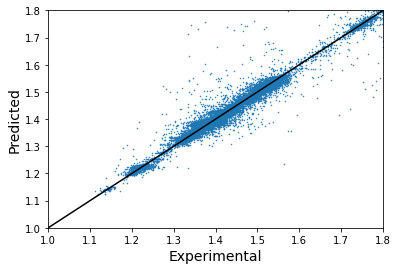

In [25]:
df = pd.DataFrame({"dists":y_test[:M].flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [26]:
from sklearn.metrics import mean_squared_error
import seaborn as sns

<AxesSubplot:ylabel='Count'>

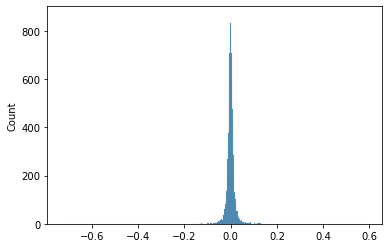

In [32]:
residuals = y_test[:M]-y_pred
sns.histplot(residuals)

In [112]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 0.0629523062426915


In [31]:
from phenixml.utils.eval_utils import tukey_test

In [36]:
outliers_prob,outliers_poss = tukey_test(residuals)

In [39]:
print(len(outliers_poss))
print(len(outliers_prob))

1559
543


In [117]:
i = sorted_error[20]
frag = frags_test[i]
print(encoder.inverse_transform(X_test[i]))
print(tokens_test[i])
print(error[i])
print(y_test[i],y_pred[i])
print()

[['C' '1' 'C']]
['C' '1' 'C']
0.2783308842534993
1.2220201918363092 1.5003510760898084



In [119]:
bond_tokenizer.featurize(frag)

['N', '2', 'O']

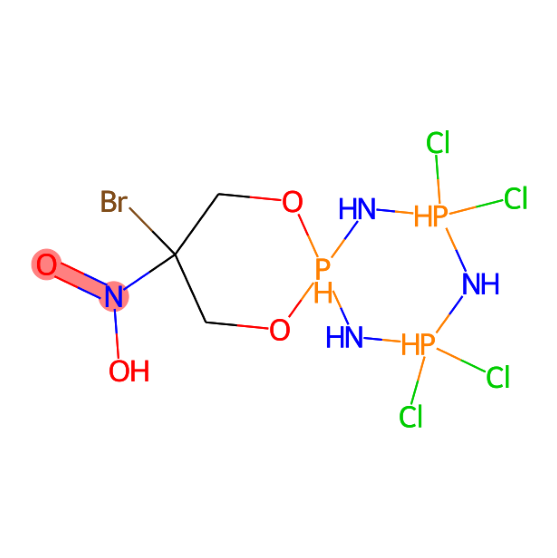

In [114]:
frag.show(only_connected=False)

In [355]:
encoder.transform?

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Signature: encoder.transform(X)
Docstring:
Transform X using one-hot encoding.

Parameters
----------
X : array-like, shape [n_samples, n_features]
    The data to encode.

Returns
-------
X_out : sparse matrix if sparse=True else a 2-d array
    Transformed input.
File:      ~/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py
Type:      method


In [356]:
encoder.inverse_transform(X_test[i])

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['C', '4', 'C']], dtype=object)

In [357]:
labels_check = encoder.inverse_transform(X_test)

In [360]:
bond_tokens2[test[i]]

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['C', '4', 'C'], dtype='<U2')

In [358]:
labels_check

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['C', '1', 'C'],
       ['O', '1', 'S'],
       ['C', '1', 'O'],
       ...,
       ['C', '1', 'N'],
       ['C', '4', 'C'],
       ['C', '4', 'C']], dtype=object)

Text(0, 0.5, 'Predicted')

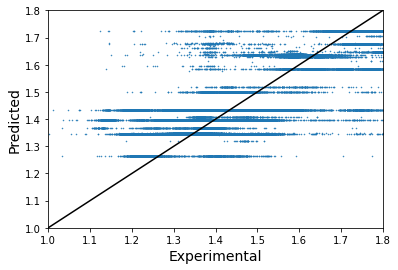

In [298]:
mode = "bond"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)